In [1]:
# This file plays the mpc motion only in viz

import time
import numpy as np
import pinocchio as pin
import crocoddyl
from matplotlib import pyplot as plt
%matplotlib notebook 

from py_biconvex_mpc.motion_planner.cpp_biconvex import BiConvexMP
from py_biconvex_mpc.ik_utils.gait_generator import GaitGenerator
from robot_properties_solo.config import Solo12Config
from mpc_gait_gen import SoloMpcGaitGen

In [2]:
robot = Solo12Config.buildRobotWrapper()
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7013/static/


In [18]:
pin_robot = Solo12Config.buildRobotWrapper()
urdf_path = Solo12Config.urdf_path
st = 0.2
dt = 5e-2
state_wt = np.array([0.] * 3 + [100] * 3 + [5.0] * (pin_robot.model.nv - 6) \
                        + [0.00] * 3 + [0.01] * 3 + [10.0] *(pin_robot.model.nv - 6))

n_eff = 4
m = pin.computeTotalMass(pin_robot.model)
q0 = np.array(Solo12Config.initial_configuration)
v0 = pin.utils.zero(pin_robot.model.nv)
x0 = np.concatenate([q0, pin.utils.zero(pin_robot.model.nv)])

v_des = np.array([0.2, 0.0, 0])
sl_arr = v_des*st
t = 0.0
step_height = 0.08


plan_freq = 0.05 # sec

gg = SoloMpcGaitGen(pin_robot, urdf_path, st, dt, state_wt, x0, plan_freq, gait = 1)

# while True:
n = 1

sim_t = 0.0
step_t = 0
sim_dt = .001
index = 0

tmp = []
tmp_des = []

# robot.robot_tsid_ctrl.set_gains(0.0, 0, 40.0, 0)

In [4]:
viz.viewer.jupyter_cell()

In [19]:
q = q0
v = v0
step_t = 0
n = 0
for o in range(50):
    contact_configuration = np.array([1,1,1,1])
    next_loc = np.array([[ 0.3946 + n*sl_arr[0],   0.14695 + n*sl_arr[1], 0],
                    [ 0.3946 + n*sl_arr[0],  -0.14695 + n*sl_arr[1], 0],
                    [ 0.0054 + n*sl_arr[0],   0.14695 + n*sl_arr[1], 0],
                    [ 0.0054 + n*sl_arr[0],  -0.14695 + n*sl_arr[1], 0]])
    
    
    xs, us, f = gg.optimize(q, v, np.round(step_t,3), n, next_loc, v_des, step_height, 5e-3, 7e-4, contact_configuration)
    if o == 0:
        plt_f = f
        plt_xs = xs
        plt_com = gg.com_int
        plt_mom = gg.mom_int
        
    else:
        plt_f = np.vstack((plt_f, f))
        plt_xs = np.vstack((plt_xs, xs))
        plt_com = np.vstack((plt_com, gg.com_int))
        plt_mom = np.vstack((plt_mom, gg.mom_int))
        
        
    gg.reset()
    for ind in range(int(plan_freq/sim_dt)):
        viz.display(xs[ind][:robot.model.nq])
    
    q = xs[-1][0:pin_robot.model.nq]
    v = xs[-1][pin_robot.model.nq:]
    step_t += plan_freq
    step_t = np.round(step_t, 2)
    if step_t >= st:
        step_t = 0
        n += 1


<IPython.core.display.Javascript object>


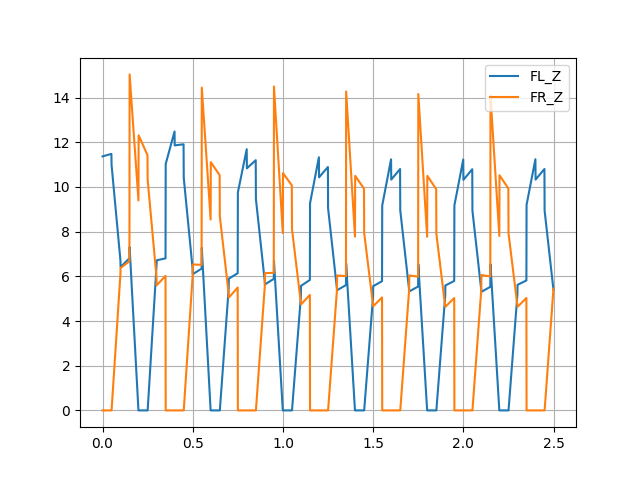

In [20]:
%matplotlib notebook 

t = 0.001*np.arange(0, len(plt_f))

fig  = plt.figure(1)
plt.plot(t, plt_f[:,2], label = "FL_Z")
plt.plot(t, plt_f[:,5], label = "FR_Z")
# ax.plot(t, plt_f[:,8], label = "HL_Z")
# ax.plot(t, plt_f[:,11], label = "HR_Z")
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


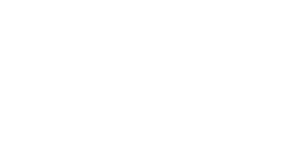

In [7]:
%matplotlib notebook 

plt.plot(t, plt_com[:,0], label = "com_x")
plt.plot(t, plt_com[:,1], label = "com_y")
plt.plot(t, plt_com[:,2], label = "com_z")
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


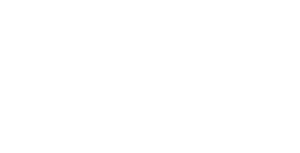

In [8]:
%matplotlib notebook 

plt.plot(t, plt_mom[:,0], label = "mom_x")
plt.plot(t, plt_mom[:,1], label = "mom_y")
plt.plot(t, plt_mom[:,2], label = "mom_z")
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


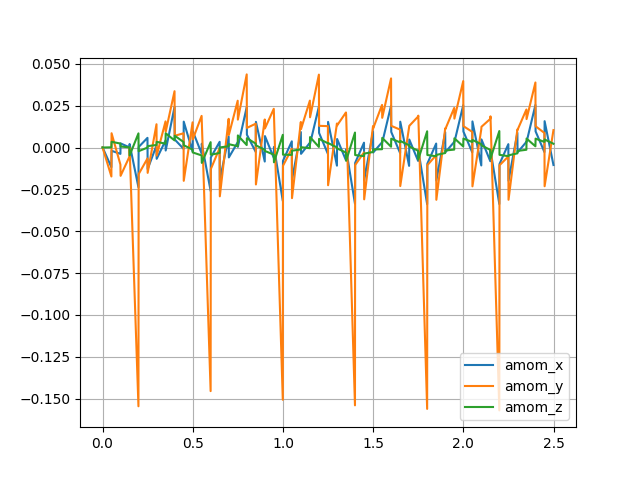

In [21]:
%matplotlib notebook 

plt.plot(t, plt_mom[:,3], label = "amom_x")
plt.plot(t, plt_mom[:,4], label = "amom_y")
plt.plot(t, plt_mom[:,5], label = "amom_z")
plt.grid()
plt.legend()
plt.show()